In [11]:
!pip install staintools
!pip install spams

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
!pip install colorcorrect

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [13]:
#Loading libraries
import os
import numpy as np
import pandas as pd
import scipy
from scipy import ndimage
import cv2
import staintools
import colorcorrect.algorithm as cca
from colorcorrect.util import from_pil, to_pil
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import re

# Creates a sorted dictionary (sorted by key)
from collections import OrderedDict


import PIL
from PIL import Image
import pickle


In [14]:
#define function saving and loading pickle
def save_obj(obj, dir_save, file_name ):
    if not os.path.exists(dir_save):
        os.mkdir(dir_save)
    
    with open(os.path.join(dir_save, file_name + '.pckl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(dir_save, file_name):
    if os.path.exists(os.path.join(dir_save, file_name + '.pckl')):
        
        with open(os.path.join(dir_save, file_name + '.pckl'), 'rb') as f:
            return pickle.load(f)
    return None


In [15]:
# setting paths
path = os.getcwd()

experiment = 'Circular_Crop' #name of folder of the experiment. Used 'Circular_Crop', 'DeepBee', 'Internal_Crop'
data_folder = 'Data'
result_folder = 'Results'

root_path = os.path.join(path,experiment)

data_path = os.path.join(root_path,data_folder)
photo_path = os.path.join(root_path,data_folder,'photos')

result_path = os.path.join(root_path,result_folder)

if not os.path.exists(os.path.join(result_path,'resized')):
    os.mkdir(os.path.join(result_path,'resized'))


result_path_objs = os.path.join(result_path, 'objs')
if not os.path.exists(result_path_objs):
    os.mkdir(result_path_objs)
unique_Labels_List = os.listdir(data_path)



data_dir = data_path
os.listdir(root_path)




['Data', 'test_images', 'train_images', 'Results']

In [16]:
# Set Params of Pipeline
normalization = 'ACE' #methods available 'ACE', 'MACENKO', 'VAHADANE' 
resize = 0.1 #for experiment Crop = 0.1, for DeepBee = 0.5
thresholding = 'OTSU' #methods available 'OTSU', 'ADAPTIVE_MEAN', 'ADAPTIVE_GAUSSIAN' 
min_Radius = 1 #set values for circle detection
max_Radius = 27 #set values for circle detection
blocksize = 7 #only adaptive thresholding
constant = 26 #only adaptive thresholding

In [17]:
###########################Circle Detection function + correlation#######################
def thresholding_Hough_correl(norm_dict, thresholding, min_Radius=1, max_Radius = 27, blocksize = 11 , constant = 0):
    
    res_img_dict = {}
    circle_dict = {}
    masked_img_dict = {}
    img_area_dict = {}
    circle_folder = 'Circle_Detection'
    circle_result_path = os.path.join(result_path, circle_folder)
    maxRadius_correl_dict = {}

    if (min_Radius >= max_Radius):
        correl = 0
    else:
        n_tot_cells = 110

        print("working on thresholding method = "+ thresholding + ", blocksize = "+  str(blocksize) + " - C = "+ str(constant) + "\n"+
            " - Hough minR = "+ str(min_Radius) + ", maxR = "+ str(max_Radius))

        for key in norm_dict.keys():
            #####################################Circle Detection######################################
            #RGB2Gray conversion
            gray = cv2.cvtColor(norm_dict[key], cv2.COLOR_BGR2GRAY)

            #Thresholding
            if thresholding == 'ADAPTIVE_MEAN':
        #        th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,np.mean(norm_dict[key])*0.01)
                th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,blocksize,constant)
            elif thresholding == 'ADAPTIVE_GAUSSIAN':
                th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,blocksize,constant)
            elif thresholding == 'OTSU':
                ret,th = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            else:
                print('continue')
                continue

            res_img_dict[key] = th

            #Save inverted Otsu's mask
            inverted_img = 255-th
            path_to_Otsu_img = os.path.join(circle_result_path, 'Mask', key)
            plt.imsave(path_to_Otsu_img, inverted_img, cmap = 'gray')

            #Hough Circle Detection on Mask
            
            circles = cv2.HoughCircles(inverted_img,cv2.HOUGH_GRADIENT,1, 10,
                                    param1=25,param2=15,minRadius=min_Radius,maxRadius=max_Radius)
            
            if circles is not None:
                circles = np.uint16(np.around(circles))
                
                circle_dict[key] = circles

                #Draw Circle on mask
                input_mask = path_to_Otsu_img
                img_test = cv2.imread(input_mask)

                # ensure at least some circles were found
                # convert the (x, y) coordinates and radius of the circles to integers
                circles = np.round(circles[0, :]).astype("int")
                
                
                # loop over the (x, y) coordinates and radius of the circles
                for (x, y, r) in circles:
                    # draw the circle in the output image, then draw a rectangle
                    # corresponding to the center of the circle
                    cv2.circle(img_test, (x, y), r, (255, 0, 0), 2) 
        
                circled_img = img_test

                #Save Circled Image
                path_to_result_img = os.path.join(circle_result_path, 'Circled_Img', key)
                plt.imsave(path_to_result_img, circled_img, cmap = 'gray')

                #Measure Cells count
                n_empty_cells = len(circles)
                if experiment == 'Circular_Crop':
                    n_t24 = n_tot_cells - n_empty_cells
                else:
                    n_t24 = n_empty_cells
 #               print(n_t24)
            else:
 #               print('no circles found')
                n_t24 = None

            img_area_dict[key] = n_t24


        img_area_dict.keys()

        # EXPORT COUNTS to dataframe where img name is the index
        img_area_df = pd.DataFrame.from_dict(img_area_dict, orient = 'index')

        # IMPORT MANUAL COUNTS
        df = pd.read_csv(os.path.join(data_path,'Correl.csv'), sep = '\t')

        #dataframe where img name is the index
        df.index = df['foto']
        
        print("merging the dataframes")
        # merge the two dataframe
        df_merge = pd.merge(df, img_area_df, left_index= True, right_index= True, how = 'inner')
        print(df_merge.shape)
        
        df_merge.columns = ('foto', 'manual', 'auto')
        df_merge = df_merge.dropna()
        if df_merge.shape[0]>3:
            r = np.corrcoef(df_merge["manual"].astype('int'), df_merge["auto"].astype('int'))
            correl = r[0,1]
            if not np.isfinite(correl):
                print("correl is nan...")
                correl = 0
        else: 
            correl = 0
    return correl

In [18]:
######################## Import Images ###############################à
img_dict = load_obj(dir_save=result_path_objs, file_name='img_dict')

if img_dict ==None:
    img_dict = load_obj(result_path_objs, 'img_dict')

    if img_dict ==None:
        img_dict = {}
        for filename in os.listdir(photo_path):
            path_to_image = os.path.join(photo_path, filename)
            image = cv2.imread(path_to_image)
            img_dict[filename] = image
    
    save_obj(dir_save=result_path_objs, file_name='img_dict', obj = img_dict)
    

print(img_dict.keys())

dict_keys(['19.jpg', '9.jpg', '6.jpg', '18.jpg', '5.jpg', '15.jpg', '1.jpg', '11.jpg', '2.jpg', '20.jpg', '14.jpg', '3.jpg', '17.jpg', '13.jpg', '4.jpg', '12.jpg', '10.jpg', '16.jpg', '7.jpg', '8.jpg'])


In [19]:
#########################Normalization######################
normalization == 'ACE'

if not os.path.exists(os.path.join(result_path,'gaussian_filter')):
    os.mkdir(os.path.join(result_path,'gaussian_filter'))

dir_smooth = os.path.join(result_path,'gaussian_filter')

if not os.path.exists(os.path.join(result_path,'Circle_Detection')):
    os.mkdir(os.path.join(result_path,'Circle_Detection'))
    os.mkdir(os.path.join(result_path,'Circle_Detection','Mask'))
    os.mkdir(os.path.join(result_path,'Circle_Detection','Circled_Img'))
    os.mkdir(os.path.join(result_path,'Circle_Detection','Masked_Circle_Img'))

if not os.path.exists(os.path.join(result_path,normalization + '_normalized')):
    os.mkdir(os.path.join(result_path,normalization + '_normalized'))

In [20]:
#########################Normalization######################
norm_dict = {}
target_path = os.path.join(data_path,'target_norm/DSC00037.JPG')

for key in img_dict.keys():
    print(key)

    path_to_result_img = os.path.join(dir_smooth, key)

    #Filtering
    if os.path.exists(path_to_result_img):
        print(key + " after gaussian exists: I'm reading it")
        gauss_img = cv2.imread(path_to_result_img)
    else:
        print(key + " after gaussian does not exist: I'm creating it")
        mf_img = cv2.medianBlur(img_dict[key], 5)     #median filter
        gauss_img = cv2.GaussianBlur(mf_img, (3,3), 5) # 3x3 gaussian blur
        plt.imsave(path_to_result_img, gauss_img)

    if normalization == 'vahadane':
        if not os.path.exists( os.path.join(result_path, normalization + '_normalized', key)):
            #Sample target img for normalization
            target = cv2.imread(target_path)
            to_transform = gauss_img

            #Stain normalization
            normalizer = staintools.StainNormalizer(method='vahadane') #method 'macenko' as alternative
            normalizer.fit(target)
            transformed = normalizer.transform(to_transform)
            
            #Save img to dict and to result folder
            norm_dict[key] = transformed
            path_to_result_img = os.path.join(result_path, normalization + '_normalized', key)
            plt.imsave(path_to_result_img, transformed)
        else:
            print("already normalized")
            
    elif normalization == 'macenko':
        if not os.path.exists(os.path.join(result_path, normalization + '_normalized', key)):        
            #Sample target img for normalization
            target = cv2.imread(target_path)
            to_transform = gauss_img
        
            #Stain normalization
            normalizer = staintools.StainNormalizer(method='macenko') #method 'vahadane' as alternative
            normalizer.fit(target)
            transformed = normalizer.transform(to_transform)
            
            #Save img to dict and to result folder
            norm_dict[key] = transformed
            path_to_result_img = os.path.join(result_path, normalization + '_normalized', key)
            plt.imsave(path_to_result_img, transformed)
        else:
            print("already normalized")

    elif normalization == 'ACE':
        if not os.path.exists( os.path.join(result_path, normalization + '_normalized', key)):
            to_transform = Image.open(os.path.join(dir_smooth, key))
            #ACE normalization and Save img to result folder
            path_to_result_img = os.path.join(result_path, normalization + '_normalized', key)

            to_pil(cca.automatic_color_equalization(from_pil(to_transform))).save(path_to_result_img)
        else:
            print("already normalized")
            
    else:
        continue

19.jpg
19.jpg after gaussian does not exist: I'm creating it
9.jpg
9.jpg after gaussian does not exist: I'm creating it
6.jpg
6.jpg after gaussian does not exist: I'm creating it
18.jpg
18.jpg after gaussian does not exist: I'm creating it
5.jpg
5.jpg after gaussian does not exist: I'm creating it
15.jpg
15.jpg after gaussian does not exist: I'm creating it
1.jpg
1.jpg after gaussian does not exist: I'm creating it
11.jpg
11.jpg after gaussian does not exist: I'm creating it
2.jpg
2.jpg after gaussian does not exist: I'm creating it
20.jpg
20.jpg after gaussian does not exist: I'm creating it
14.jpg
14.jpg after gaussian does not exist: I'm creating it
3.jpg
3.jpg after gaussian does not exist: I'm creating it
17.jpg
17.jpg after gaussian does not exist: I'm creating it
13.jpg
13.jpg after gaussian does not exist: I'm creating it
4.jpg
4.jpg after gaussian does not exist: I'm creating it
12.jpg
12.jpg after gaussian does not exist: I'm creating it
10.jpg
10.jpg after gaussian does not 

In [21]:
############# Resizing while extracting train and test images ############
from random import random

struct_load = load_obj(dir_save = result_path_objs, file_name = 'all_norm_dicts')

if struct_load == None:
    if normalization == '':
        norm_path = dir_smooth
    else:
        norm_path = os.path.join(result_path, normalization+'_normalized')

    norm_dict = {}
    norm_dict_train = {}
    idx_train = []
    norm_dict_test = {}
    num_train = 50
    count = 0
    idx = 0
    for filename in img_dict.keys():
        path_to_image = os.path.join(norm_path, filename)
        print(path_to_image)
        
        image = cv2.imread(path_to_image)
        
        scale_percent = resize # percent of original size
        width = int(image.shape[1] * scale_percent)
        height = int(image.shape[0] * scale_percent)
        dim = (width, height)
        # resize image
        resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

        norm_dict[filename] = resized
        if (random()>0.5) & (count < num_train):
            norm_dict_train[filename] = resized
            idx_train.append(idx)
            count = count+1
        else:
            norm_dict_test[filename] = resized
        
        #Save img to dict and to result folder
        path_to_result_img = os.path.join(result_path, 'resized', filename)
        plt.imsave(path_to_result_img, resized)
        idx = idx+1
else:
    norm_dict = struct_load[0]
    norm_dict_test = struct_load[1] 
    norm_dict_train = struct_load[2]

/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/19.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/9.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/6.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/18.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/5.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/15.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/1.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/11.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/2.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/20.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_normalized/14.jpg
/home/gpaolillo/Desktop/Comb_Images-main/Circular_Crop/Results/ACE_nor

In [22]:
print(norm_dict.keys())

dict_keys(['19.jpg', '9.jpg', '6.jpg', '18.jpg', '5.jpg', '15.jpg', '1.jpg', '11.jpg', '2.jpg', '20.jpg', '14.jpg', '3.jpg', '17.jpg', '13.jpg', '4.jpg', '12.jpg', '10.jpg', '16.jpg', '7.jpg', '8.jpg'])


In [23]:
print(norm_dict_test.keys())

dict_keys(['19.jpg', '6.jpg', '18.jpg', '5.jpg', '15.jpg', '11.jpg', '2.jpg', '20.jpg', '10.jpg', '16.jpg'])


In [24]:
print(norm_dict_train.keys())

dict_keys(['9.jpg', '1.jpg', '14.jpg', '3.jpg', '17.jpg', '13.jpg', '4.jpg', '12.jpg', '7.jpg', '8.jpg'])


In [25]:
################################################### GRID SEARCH #####################################

In [26]:
############### OTSU MAX RADIUS PARAM SEARCH ##################

In [27]:
thresholding ='OTSU'
minR= 1
maxR= 25
blocksize = 0
constant = 0
norm_dict = norm_dict_train

correl = thresholding_Hough_correl(norm_dict_train,thresholding = thresholding,min_Radius = minR,max_Radius = maxR,blocksize= None,constant = None)
print(correl)

working on thresholding method = OTSU, blocksize = None - C = None
 - Hough minR = 1, maxR = 25
merging the dataframes
(10, 3)
0.8693794785396107


working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 2
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 3
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 4
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 5
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 6
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 7
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 8
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 9
merging the dataframes
(10, 3)
working on thresholding method =

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 70
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 71
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 72
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 73
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 74
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 75
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 76
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 77
merging the dataframes
(

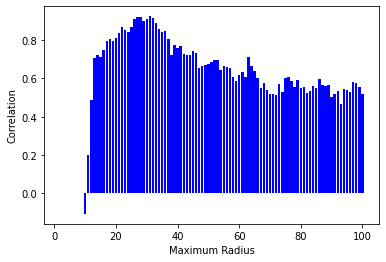

all correlation Values 
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 -0.10720978243303181
11 0.19943639434747343
12 0.4853123960725424
13 0.7095185727964618
14 0.7237811293725147
15 0.712330465455951
16 0.7468469177843924
17 0.7951051159023391
18 0.8070268171328892
19 0.79707709145055
20 0.8122461538045831
21 0.8398781322362928
22 0.8669791854547244
23 0.8537339509704291
24 0.8410939422877121
25 0.8693794785396107
26 0.9093971219706869
27 0.9202451201040608
28 0.9219927150467526
29 0.9020866327263259
30 0.9110585071022891
31 0.9250142780536017
32 0.9153406688001471
33 0.8914447307049114
34 0.8564588207795897
35 0.8445201822034536
36 0.8503315244751514
37 0.8042667930678944
38 0.7233159169913089
39 0.7754666906847612
40 0.75779604433068
41 0.7688508194473354
42 0.725797557853273
43 0.7252120261098164
44 0.7224372723539845
45 0.7447112556176372
46 0.7333477541520556
47 0.6540472142326196
48 0.6644764975007844
49 0.6716476660212932
50 0.6743455219887636
51 0.6859937065073948
52 0.6977769264247039
5

In [28]:
file_name = 'maxR_OTSU_correl_dict'

struct_load =  load_obj(dir_save = result_path_objs, file_name = file_name)

if struct_load == None:
    OTSU_correl_dict = {}
    minv = 2
    maxv = 101
    stepv = 1
    for maxR in range(minv,maxv,stepv):
        correl = thresholding_Hough_correl(norm_dict_train,thresholding = 'OTSU',max_Radius=maxR)
        key = 'maxRadius' + str(maxR)
        OTSU_correl_dict[maxR] = correl

    plt.bar(list(range(minv,maxv,stepv)), OTSU_correl_dict.values(), color='b')
    #plt.title('OTSU MAX RADIUS CORRELATION')
    plt.xlabel('Maximum Radius')
    plt.ylabel('Correlation')
    plt.savefig(os.path.join(result_path, 'OTSU_maxRadius_plot.pdf'))
    plt.show()


    print("all correlation Values ")
    for k, v in OTSU_correl_dict.items(): print(k, v)

    # get key with max value
    best_maxRadius = max(OTSU_correl_dict, key=OTSU_correl_dict.get)


    print("best correlation = "+str(OTSU_correl_dict[best_maxRadius])+" at Radius =" + str(best_maxRadius))

    save_obj(obj = (OTSU_correl_dict, best_maxRadius), dir_save = result_path_objs, file_name = 'maxR_OTSU_correl_dict')

else:
    OTSU_correl_dict = struct_load[0] 
    best_maxRadius = struct_load[1]


working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 31
merging the dataframes
(10, 3)
working on thresholding 

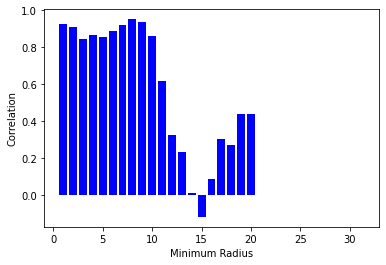

all correlation Values 
1 0.9250142780536017
2 0.907501160641394
3 0.8451567265282973
4 0.867402303276338
5 0.8543184727083577
6 0.889151281037129
7 0.9211000898563364
8 0.9516000299869942
9 0.9384031808240073
10 0.8629066936871237
11 0.6186570539964877
12 0.3277926419210602
13 0.23584609490787004
14 0.011226119608099527
15 -0.11710061970488769
16 0.08820847225176333
17 0.30647008364079253
18 0.27108652350459334
19 0.43759497449368373
20 0.4375949744936837
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
best correlation = 0.9516000299869942 at Radius =8


In [29]:
file_name = 'minR_OTSU_correl_dict'

struct_load =  load_obj(dir_save = result_path_objs, file_name = file_name)


if struct_load == None:

    min_OTSU_correl_dict = {}

    minv =1
    for minR in range(minv,best_maxRadius+1,stepv):
        correl = thresholding_Hough_correl(norm_dict_train,thresholding = thresholding,min_Radius = minR,max_Radius=best_maxRadius)
        min_OTSU_correl_dict[minR] = correl

    plt.bar(list(range(minv,best_maxRadius+1,stepv)), min_OTSU_correl_dict.values(), color='b')
    #plt.title('OTSU MAX RADIUS CORRELATION')
    plt.xlabel('Minimum Radius')
    plt.ylabel('Correlation')
    plt.savefig(os.path.join(result_path, 'OTSU_minRadius_plot.pdf'))
    plt.show()


    print("all correlation Values ")
    for k, v in min_OTSU_correl_dict.items(): print(k, v)



    # get key with max value
    best_minRadius = max(min_OTSU_correl_dict, key=min_OTSU_correl_dict.get)


    print("best correlation = "+str(min_OTSU_correl_dict[best_minRadius])+" at Radius =" + str(best_minRadius))


    save_obj(obj = (min_OTSU_correl_dict, best_minRadius), dir_save = result_path_objs, file_name = 'minR_OTSU_correl_dict')

else:
    min_OTSU_correl_dict = struct_load[0] 
    best_minRadius = struct_load[1]

In [30]:
print(best_minRadius, best_maxRadius)

8 31


In [31]:
##################### TWO PARAM OTSU GRID PARAM SEARCH ######################À

In [32]:
struct_load = load_obj(dir_save = result_path_objs, file_name = 'twoWay_OTSU_correl_dict')
maxv = 75
if struct_load ==None:

    #if struct_load ==None:
    two_param_OTSU_correl_dict = {}
    maxv = 75
    df_otsu = np.zeros(shape=(maxv,maxv))

    for min_Radius in range(1,maxv+1,1):
        for max_Radius in range(1,maxv+1,1):
            correl = thresholding_Hough_correl(norm_dict_train,'OTSU',min_Radius,max_Radius)
            key = (min_Radius,max_Radius)
            two_param_OTSU_correl_dict[key] = correl
            df_otsu[min_Radius-1, max_Radius-1] = correl
        
    # get key with max value
    (best_minR_twoWay, best_maxR_twoWay) = max(two_param_OTSU_correl_dict, key=two_param_OTSU_correl_dict.get)

    print("best correlation = "+str(two_param_OTSU_correl_dict[(best_minR_twoWay, best_maxR_twoWay)])+" at Radiuses =" + str((best_minR_twoWay, best_maxR_twoWay)))
    save_obj( obj = (two_param_OTSU_correl_dict, df_otsu, best_minR_twoWay, best_maxR_twoWay), dir_save = result_path_objs, file_name = 'twoWay_OTSU_correl_dict')
else:
    two_param_OTSU_correl_dict = struct_load[0] 
    df_otsu = struct_load[1]
#    (best_minR_twoWay, best_maxR_twoWay) = max(df_otsu, key=df_otsu.get)
    best_minR_twoWay = struct_load[2] 
    best_maxR_twoWay = struct_load[3]

print('\n'+'correlation on train images with best params from 2d grid search:' +str(df_otsu[best_minR_twoWay-1,best_maxR_twoWay-1]))
#################### OTSU CORRELATION ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = thresholding,min_Radius = best_minR_twoWay, max_Radius=best_maxR_twoWay)

print("correlation on test images with best params from 2D grid search: minR = "+str(best_minR_twoWay)+" - maxR = "+ str(best_maxR_twoWay) + " = " + str(correl))

working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 2
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 3
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 4
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 5
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 6
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 7
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 8
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 9
merging the dataframes
(10, 3)
working on thresholding method =

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 70
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 71
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 72
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 73
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 74
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 1, maxR = 75
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 3
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 4
merging the dataframes
(10

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 65
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 66
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 67
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 68
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 69
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 70
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 71
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 2, maxR = 72
merging the dataframes
(

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 65
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 66
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 67
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 3, maxR = 68
merging the dataframes
(

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 65
merging the dataframes
(

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 5, maxR = 63
merging the dataframes
(

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 55
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 6, maxR = 62
merging the dataframes
(

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 55
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 7, maxR = 62
merging the dataframes
(

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 8, maxR = 63
merging the dataframes
(

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 65
merging the dataframes
(

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 10, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 10, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 10, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 10, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 10, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 10, maxR = 65
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 10, maxR = 66
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 10, maxR = 67
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 11, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 11, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 11, maxR = 65
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 11, maxR = 66
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 11, maxR = 67
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 11, maxR = 68
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 11, maxR = 69
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 11, maxR = 70
merging the data

/home/gpaolillo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/gpaolillo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 12, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 12, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 12, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 12, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 12, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 12, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 12, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 12, maxR = 34
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 13, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 13, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 13, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 13, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 13, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 13, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 13, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 13, maxR = 39
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 14, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 14, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 14, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 14, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 14, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 14, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 14, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 14, maxR = 45
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 15, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 15, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 15, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 15, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 15, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 15, maxR = 50
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 15, maxR = 51
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 15, maxR = 52
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 16, maxR = 53
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 16, maxR = 54
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 16, maxR = 55
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 16, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 16, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 16, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 16, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 16, maxR = 60
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 17, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 17, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 17, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 17, maxR = 65
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 17, maxR = 66
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 17, maxR = 67
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 17, maxR = 68
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 17, maxR = 69
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 18, maxR = 72
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 18, maxR = 73
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 18, maxR = 74
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 18, maxR = 75
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 19, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 19, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 19, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 19, maxR = 23
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 20, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 20, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 20, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 20, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 20, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 20, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 20, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 20, maxR = 37
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 21, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 21, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 21, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 21, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 21, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 21, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 21, maxR = 50
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 21, maxR = 51
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 22, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 22, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 22, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 22, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 22, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 22, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 22, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 22, maxR = 65
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 23, maxR = 73
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 23, maxR = 74
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 23, maxR = 75
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 24, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 24, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 24, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 24, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 24, maxR = 29
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 25, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 25, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 25, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 25, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 25, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 25, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 25, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 25, maxR = 47
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 26, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 26, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 26, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 26, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 26, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 26, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 26, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 26, maxR = 65
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 28, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 28, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 28, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 28, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 28, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 28, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 28, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 28, maxR = 39
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 29, maxR = 53
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 29, maxR = 54
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 29, maxR = 55
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 29, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 29, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 29, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 29, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 29, maxR = 60
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 30, maxR = 75
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 31, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 31, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 31, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 31, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 31, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 31, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 31, maxR = 38
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 32, maxR = 55
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 32, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 32, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 32, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 32, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 32, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 32, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 32, maxR = 62
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 34, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 34, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 34, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 34, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 34, maxR = 45
merging the dataframes
(10, 3)
correl is nan...
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 34, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 34, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 34, maxR = 48

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 35, maxR = 68
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 35, maxR = 69
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 35, maxR = 70
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 35, maxR = 71
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 35, maxR = 72
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 35, maxR = 73
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 35, maxR = 74
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 35, maxR = 75
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 37, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 37, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 37, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 37, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 37, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 37, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 37, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 37, maxR = 65
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 39, maxR = 52
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 39, maxR = 53
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 39, maxR = 54
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 39, maxR = 55
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 39, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 39, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 39, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 39, maxR = 59
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 41, maxR = 51
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 41, maxR = 52
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 41, maxR = 53
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 41, maxR = 54
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 41, maxR = 55
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 41, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 41, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 41, maxR = 58
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 43, maxR = 53
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 43, maxR = 54
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 43, maxR = 55
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 43, maxR = 56
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 43, maxR = 57
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 43, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 43, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 43, maxR = 60
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 45, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 45, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 45, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 45, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 45, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 45, maxR = 65
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 45, maxR = 66
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 45, maxR = 67
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 47, maxR = 70
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 47, maxR = 71
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 47, maxR = 72
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 47, maxR = 73
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 47, maxR = 74
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 47, maxR = 75
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 48, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 48, maxR = 50
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 50, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 50, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 50, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 50, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 50, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 50, maxR = 65
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 50, maxR = 66
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 50, maxR = 67
merging the data

(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 53, maxR = 58
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 53, maxR = 59
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 53, maxR = 60
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 53, maxR = 61
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 53, maxR = 62
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 53, maxR = 63
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 53, maxR = 64
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 53, maxR = 65
merging the dataframes
(10, 3)
working 

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 56, maxR = 66
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 56, maxR = 67
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 56, maxR = 68
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 56, maxR = 69
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 56, maxR = 70
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 56, maxR = 71
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 56, maxR = 72
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 56, maxR = 73
merging the data

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 60, maxR = 69
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 60, maxR = 70
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 60, maxR = 71
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 60, maxR = 72
merging the dataframes
(10, 3)
correl is nan...
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 60, maxR = 73
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 60, maxR = 74
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 60, maxR = 75
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 61, maxR = 62

merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 66, maxR = 68
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 66, maxR = 69
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 66, maxR = 70
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 66, maxR = 71
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 66, maxR = 72
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 66, maxR = 73
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 66, maxR = 74
merging the dataframes
(10, 3)
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 66, maxR = 75
merging the data

In [33]:
best_minR_twoWay, best_maxR_twoWay

(9, 33)

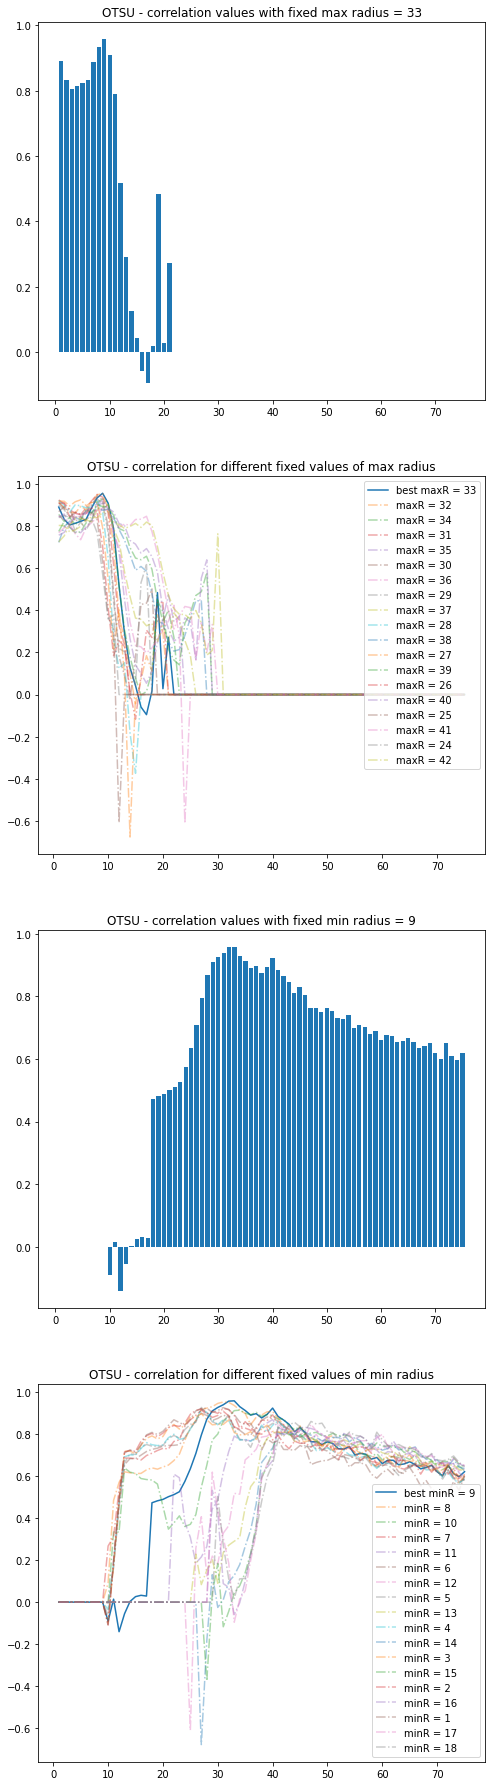

In [34]:
fig, ax_bar = plt.subplots(4,1, figsize=(8,32))

ax_bar[0].bar(np.arange(1,maxv+1,1),df_otsu[:,best_maxR_twoWay-1])
ax_bar[0].set_title('OTSU - correlation values with fixed max radius = '+str(best_maxR_twoWay))

ax_bar[1].plot(np.arange(1,maxv+1,1),df_otsu[:, best_maxR_twoWay-1], label='best maxR = ' + str(best_maxR_twoWay))
for j in np.arange(1,10,1):
    ax_bar[1].plot(np.arange(1,maxv+1,1),df_otsu[:, best_maxR_twoWay-1-j], '-.', alpha = 0.4,  label="maxR = " +str(best_maxR_twoWay-j))
    ax_bar[1].plot(np.arange(1,maxv+1,1),df_otsu[:, best_maxR_twoWay-1+j], '-.', alpha = 0.4, label="maxR = " +str(best_maxR_twoWay+j))
ax_bar[1].legend(loc = 'upper right')
ax_bar[1].set_title('OTSU - correlation for different fixed values of max radius')


ax_bar[2].bar(np.arange(1,maxv+1,1),df_otsu[best_minR_twoWay-1,:])
ax_bar[2].set_title('OTSU - correlation values with fixed min radius = '+str(best_minR_twoWay))

ax_bar[3].plot(np.arange(1,maxv+1,1),df_otsu[best_minR_twoWay-1,:], label='best minR = ' + str(best_minR_twoWay))
for j in np.arange(1,10,1):
    if (best_minR_twoWay-j >0):
        ax_bar[3].plot(np.arange(1,maxv+1,1),df_otsu[best_minR_twoWay-1-j,:], '-.', alpha = 0.4,  label="minR = " +str(best_minR_twoWay-j))
    ax_bar[3].plot(np.arange(1,maxv+1,1),df_otsu[best_minR_twoWay-1+j,:], '-.', alpha = 0.4, label="minR = " +str(best_minR_twoWay+j))
ax_bar[3].legend(loc = 'lower right')
ax_bar[3].set_title('OTSU - correlation for different fixed values of min radius')

plt.savefig(os.path.join(result_path, 'OTSU_minMaxRadius_distribution.pdf'))



(13, 39) (13, 39) (13, 39)


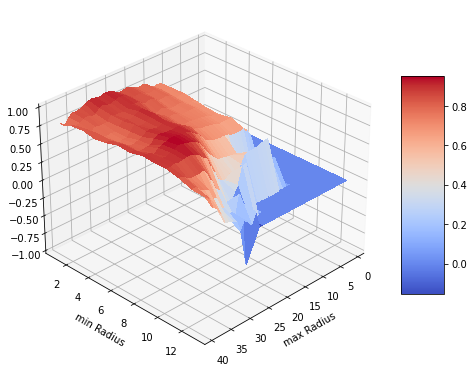

In [35]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))

# Make data.
maxMinR = 14
maxMaxR = 40
Y = np.arange(1,maxMinR, 1)
X = np.arange(1,maxMaxR, 1)
X, Y = np.meshgrid(X, Y)
df_otsu[np.where(np.isnan(df_otsu))] = 0
Z = df_otsu[np.arange(0,maxMinR-1,1),:]
Z = Z[:, np.arange(0,maxMaxR-1,1)]

print(X.shape, Y.shape, Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.00, 1.00)
#ax.zaxis.set_major_locator(LinearLocator(0))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('max Radius')
ax.set_ylabel('min Radius')
#ax.view_init(20, +30)
ax.view_init(30, +45)
#ax.set_title('OTSU MIN MAX RADIUS CORRELATION')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig(os.path.join(result_path, 'OTSU_minMaxRadius_surface.pdf'))

plt.show()


In [36]:
print(df_otsu)

[[0.         0.         0.         ... 0.57356984 0.53102756 0.60065284]
 [0.         0.         0.         ... 0.63603131 0.58752224 0.60834886]
 [0.         0.         0.         ... 0.61908646 0.56694232 0.60220487]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [37]:
################################# ADAPTIVE THRESHOLDING ########################

In [38]:
######################## ADAPTIVE MEAN THREE PARAMS GRID SEARCH######################

In [39]:
maxC = 60
minBsize = 3
maxBsize = 50

maxRadius = 50
minR =  best_minR_twoWay
struct_load = load_obj(dir_save = result_path_objs, file_name = 'adaptive_mean_correl_dict')

if struct_load==None:

    adaptive_mean_correl_dict = {}

    df_adaptive_mean = np.zeros(shape=(len(range(0,maxC,4)),len(range(minBsize,maxBsize,2)), 1, maxRadius ))
    
    idx_C =-1   
    #for maxRadius in range(11,41,2):
    for C in range(0,maxC,4):
        idx_C = idx_C + 1  
        idx_b =-1
        for bsize in range(minBsize,maxBsize,4):
            idx_b = idx_b + 1
            #for minR in best_minR_twoWay:
            for maxR in range(15,45,1):            
                correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_MEAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                adaptive_mean_correl_dict[(bsize, C, minR, maxR)] = correl  
                df_adaptive_mean[idx_C, idx_b, 0, maxR-1] = correl

    save_obj( obj = (adaptive_mean_correl_dict, df_adaptive_mean), dir_save = result_path_objs, file_name = 'adaptive_mean_correl_dict')
else:
    adaptive_mean_correl_dict = struct_load[0] 
    df_adaptive_mean = struct_load[1]

    # get key with max value
(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive) = max(adaptive_mean_correl_dict, key=adaptive_mean_correl_dict.get)

print("best correlation on training set = "+str(adaptive_mean_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE MEAN ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_MEAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 0
 - Hough minR = 9, m

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize =

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 4
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 4
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 4
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 4
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 4
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 4
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 4
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 4
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 4
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 4
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 4
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 4
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 4
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 4
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 4
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 4
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 4
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 4
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 4
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 4
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 4
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 4
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 4
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 4
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 4
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 4
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 4
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 4
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 4
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 4
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 4
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 8
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 8
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 8
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 8
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 8
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 8
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 8
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize =

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 8
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 8
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 8
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 8
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 8
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 8
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 8
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 8
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 8
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 8
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 8
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 8
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 8
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 8
 - Hough min

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 8
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 8
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 8
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 8
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 8
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 8
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 8
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 8
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 8
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 8
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 8
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 8
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 8
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 8
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 12
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 12
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 12
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 12
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 12
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 12
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 12
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 12
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 12
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 12
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 12
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 12
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 12
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 12
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 12
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 12
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 12
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 12
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 12
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 12
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 12
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 16
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 16
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 16
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 16
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 16
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 16
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 16
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 16
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 16
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 16
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 16
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 16
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 16
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 16
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 16
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 16
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 16
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 20
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 20
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 20
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 20
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 24
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 24
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 24
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 24
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 24
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 24
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blo

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 24
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 24
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 24
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 24
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 24
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 24
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 24
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 24
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 24
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 24
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 24
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 24
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 24
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 24
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 24
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 24
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 24
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 24
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 24
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 24
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 24
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 24
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 24
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 24
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 24
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 24
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 24
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 24
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 28
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 28
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 28
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 28
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 28
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 28
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 28
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 28
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 28
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 28
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 28
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 28
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 28
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 28
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 28
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 28
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 32
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 32
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 32
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 32
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 32
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 32
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 32
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 32
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 32
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 32
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 32
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 32
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 32
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 32
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 32
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 32
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 32
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 32
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 32
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 32
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 32
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 32
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 32
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 32
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 32
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 32
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 32
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 32
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 32
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 32
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 32
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 32
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 32
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 32
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 32
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 32
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 32
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 32
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
correl is nan...
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 17


/home/gpaolillo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/gpaolillo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 40
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 40
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 40
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 40
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 40
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 40
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 40
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 40
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 40
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 40
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 40
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 40
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 40
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 40
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 40
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 40
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 40
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 40
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 40
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 40
 - H

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 40
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 40
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 40
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 40
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 40
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 40
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 40
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 44
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 48
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 48
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 48
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 48
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 48
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 48
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 48
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 48
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 48
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 48
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 48
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 48
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 48
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 48
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 48
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 48
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 48
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 48
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 48
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 48
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 19 - C = 48
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 48
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 48
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 48
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 48
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 48
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 48
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 27 - C = 48
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 48
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 48
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 48
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 48
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 48
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 48
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 35 - C = 48
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 48
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 48
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 48
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 48
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 48
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 48
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 48
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 52
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 52
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 52
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 52
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 52
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 3 - C = 52
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 52
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 52
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 52
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 11 - C = 52
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, bloc

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 56
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 56
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 56
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 56
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 56
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 56
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 15 - C = 56
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 56
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 56
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 56
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 56
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 56
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 56
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 23 - C = 56
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 56
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 56
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 56
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 56
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 56
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 56
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 56
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 56
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 56
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 56
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 39 - C = 56
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 47 - C = 56
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
best correlation on training set = 0.9584006383147712 at Radiuses = 9, 30 - C = 28 - blocksize = 31
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
correlation on test images [with best params: minR = 9 - maxR = 30 - C = 28 - blocksize31] = 0.8789324480018342


In [40]:
######################## ADAPTIVE MEAN BEST C AND BSIZE RADIUSES SEARCH######################

In [41]:
bsize = best_b_size_adaptive
C = best_C_adaptive    
maxRadius = 50

struct_load = load_obj(dir_save = result_path_objs, file_name = 'adaptive_mean_correl_dict_radiuses')

if struct_load==None:
    print('create dict')
    adaptive_mean_correl_dict = {}
    df_adaptive_mean = np.zeros(shape=(maxRadius, maxRadius ))
    for minR in range(1,maxRadius,1):
        for maxR in range(minR+1,maxRadius,1):            
            correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_MEAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
            adaptive_mean_correl_dict[(minR, maxR)] = correl  
            df_adaptive_mean[minR-1, maxR-1] = correl

    save_obj( obj = (adaptive_mean_correl_dict, df_adaptive_mean), dir_save = result_path_objs, file_name = 'adaptive_mean_correl_dict_radiuses')
else:
    adaptive_mean_correl_dict = struct_load[0] 
    df_adaptive_mean = struct_load[1]

    # get key with max value
(best_minR_adaptive, best_maxR_adaptive) = max(adaptive_mean_correl_dict, key=adaptive_mean_correl_dict.get)

print("best correlation = "+str(adaptive_mean_correl_dict[(best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE MEAN CORRELATION ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_MEAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


create dict
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 1, maxR = 2
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 1, maxR = 3
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 1, maxR = 4
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 1, maxR = 5
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 1, maxR = 6
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 1, maxR = 7
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 1, maxR = 8
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 2, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 2, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 3, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 3, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 3, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 3, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 3, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 3, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 3, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 5, maxR = 11
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 5, maxR = 12
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 5, maxR = 13
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 5, maxR = 14
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 5, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 5, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 5, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 6, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 6, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 6, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 6, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 6, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 8, maxR = 12
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 8, maxR = 13
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 8, maxR = 14
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 8, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 8, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 8, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 8, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEA

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 11, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 11, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 11, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 11, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 11, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 11, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 11, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 12, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 12, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 12, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 12, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 13, maxR = 14
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 13, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 13, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 14, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 14, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 14, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 14, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 14, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 14, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 14, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 16, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 16, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 16, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 16, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 16, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 16, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 16, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 18, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 18, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 18, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 18, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 18, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 18, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 18, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 20, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 20, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 20, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 20, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 20, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 20, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 20, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 22, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 22, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 22, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 22, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 22, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 22, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 23, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 25, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 25, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 25, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 25, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 25, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 25, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 25, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 28, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 28, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 28, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 28, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 28, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 28, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 28, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 31, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 31, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 31, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 31, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 31, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 31, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 31, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 35, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 35, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 35, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 35, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 35, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 35, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 35, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 40, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 40, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 40, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 40, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 41, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 41, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_MEAN, blocksize = 31 - C = 28
 - Hough minR = 41, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPT

In [42]:
############ GLOBAL ADAPTIVE MEAN PARAM SEARCH ####################

In [43]:
struct_load = load_obj(dir_save = result_path_objs, file_name = 'global_adaptive_mean_correl_dict')

if struct_load==None:

    adaptive_mean_correl_dict = {}

    df_adaptive_mean = np.zeros(shape=(10, 5, 9, 9))

    idx_C =-1   
    #for maxRadius in range(11,41,2):
    for C in range(best_C_adaptive-9,best_C_adaptive+10,2):
        idx_C = idx_C + 1  
        idx_b =-1
        if best_b_size_adaptive == 3:
            for bsize in range(best_b_size_adaptive,best_b_size_adaptive+9,2):
                idx_b = idx_b + 1
                idx_minR =-1
                for minR in range(best_minR_adaptive-4,best_minR_adaptive+5,1):
                    idx_minR = idx_minR + 1
                    idx_maxR =-1
                    for maxR in range(best_maxR_adaptive-4,best_maxR_adaptive+5,1):
                        idx_maxR = idx_maxR + 1
                        correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                        adaptive_mean_correl_dict[(bsize, C, minR, maxR)] = correl  
                        df_adaptive_mean[idx_C, idx_b, idx_minR, idx_maxR] = correl
        else:
            for bsize in range(best_b_size_adaptive-4,best_b_size_adaptive+5,2):
                idx_b = idx_b + 1
                idx_minR =-1
                for minR in range(best_minR_adaptive-4,best_minR_adaptive+5,1):
                    idx_minR = idx_minR + 1
                    idx_maxR =-1
                    for maxR in range(best_maxR_adaptive-4,best_maxR_adaptive+5,1):
                        idx_maxR = idx_maxR + 1
                        correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                        adaptive_mean_correl_dict[(bsize, C, minR, maxR)] = correl  
                        df_adaptive_mean[idx_C, idx_b, idx_minR, idx_maxR] = correl

    save_obj( obj = (adaptive_mean_correl_dict, df_adaptive_mean), dir_save = result_path_objs, file_name = 'global_adaptive_mean_correl_dict')
else:
    adaptive_mean_correl_dict = struct_load[0] 
    df_adaptive_mean = struct_load[1]

    # get key with max value
(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive) = max(adaptive_mean_correl_dict, key=adaptive_mean_correl_dict.get)

print("best correlation on training set = "+str(adaptive_mean_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE MEAN ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_MEAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = -3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = -3, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = -3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = -3, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = -3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = -3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = -3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = 3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = 3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = 4, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = 4, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = 4, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = 4, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 19
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresh

 - Hough minR = 1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 19
 - Hough minR = 1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 19
 - Hough minR = 1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 19
 - Hough minR = 1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 19
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 19
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 19
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 19
 - Hough minR = 2, maxR = 24
merging the datafra

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 19
 - Hough minR = -1, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 19
 - Hough minR = -1, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 19
 - Hough minR = -1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 19
 - Hough minR = -1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 19
 - Hough minR = -1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 19
 - Hough minR = -1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 19
 - Hough minR = 0, maxR = 21
merging the dataframes
(10, 3)
working on 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = -3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = -3, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = -3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = -3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = -3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = -3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = -3, maxR = 29
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = 4, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = 4, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = 4, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = 4, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 19
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 19
 - Hough minR = 1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 19
 - Hough minR = 1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 19
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 19
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 19
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 19
 - Hough minR = 2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 19
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 21
 - Hough minR = -1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 21
 - Hough minR = -1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 21
 - Hough minR = -1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 21
 - Hough minR = -1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 21
 - Hough minR = 0, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 21
 - Hough minR = 0, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 21
 - Hough minR = 0, maxR = 23
merging the dataframes
(10, 3)
working on th

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = -3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = -3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = -3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = -3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = -3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = -2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = -2, maxR = 22
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = 4, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = 4, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 21
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 21
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 21
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 21
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 21
 - Hough minR = 2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 21
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 21
 - Hough minR = 2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 21
 - Hough minR = 2, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 21
 - Hough minR = -1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 21
 - Hough minR = -1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 21
 - Hough minR = 0, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 21
 - Hough minR = 0, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 21
 - Hough minR = 0, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 21
 - Hough minR = 0, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 21
 - Hough minR = 0, maxR = 25
merging the dataframes
(10, 3)
working on thre

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = -3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = -3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = -3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = -3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = -2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = -2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = -2, maxR = 23
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = 5, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 21
 - Hough minR = 5, maxR = 22
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 23
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 23
 - Hough minR = 2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 23
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 23
 - Hough minR = 2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 23
 - Hough minR = 2, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 23
 - Hough minR = 2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 23
 - Hough minR = 2, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 23
 - Hough minR = 0, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 23
 - Hough minR = 0, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 23
 - Hough minR = 0, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 23
 - Hough minR = 0, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 23
 - Hough minR = 0, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 23
 - Hough minR = 0, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 23
 - Hough minR = 0, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = -3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = -3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = -2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = -2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = -2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = -2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = -2, maxR = 25
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = 5, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = 5, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = 5, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 23
 - Hough minR = 5, maxR = 24
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 23
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 23
 - Hough minR = 2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 23
 - Hough minR = 2, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 23
 - Hough minR = 2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 23
 - Hough minR = 2, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 23
 - Hough minR = 3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 23
 - Hough minR = 3, maxR = 22
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 23
 - Hough minR = 0, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 23
 - Hough minR = 0, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 23
 - Hough minR = 0, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 23
 - Hough minR = 0, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 23
 - Hough minR = 0, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 23
 - Hough minR = 0, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 23
 - Hough minR = 0, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = -2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = -2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = -2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = -2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = -2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = -2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = -2, maxR = 27
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = 5, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = 5, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = 5, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = 5, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 25
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresh

working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 25
 - Hough minR = 2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 25
 - Hough minR = 2, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 25
 - Hough minR = 2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 25
 - Hough minR = 2, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 25
 - Hough minR = 3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 25
 - Hough minR = 3, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 25
 - Hough minR = 3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSI

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 25
 - Hough minR = 0, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 25
 - Hough minR = 0, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 25
 - Hough minR = 0, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 25
 - Hough minR = 0, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 25
 - Hough minR = 0, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 25
 - Hough minR = 1, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 25
 - Hough minR = 1, maxR = 22
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = -2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = -2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = -2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = -2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = -2, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = -2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = -2, maxR = 29
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = 5, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = 5, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = 5, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = 5, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 25
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 25
 - Hough minR = 2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 25
 - Hough minR = 2, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 25
 - Hough minR = 3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 25
 - Hough minR = 3, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 25
 - Hough minR = 3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 25
 - Hough minR = 3, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 25
 - Hough minR = 3, maxR = 25
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 27
 - Hough minR = 0, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 27
 - Hough minR = 0, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 27
 - Hough minR = 0, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 27
 - Hough minR = 0, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 27
 - Hough minR = 1, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 27
 - Hough minR = 1, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 27
 - Hough minR = 1, maxR = 23
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = -2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = -2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = -2, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = -2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = -2, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = -1, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = -1, maxR = 22
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = 5, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = 5, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = 5, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 27
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 27
 - Hough minR = 3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 27
 - Hough minR = 3, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 27
 - Hough minR = 3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 27
 - Hough minR = 3, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 27
 - Hough minR = 3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 27
 - Hough minR = 3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 27
 - Hough minR = 3, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 27
 - Hough minR = 0, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 27
 - Hough minR = 0, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 27
 - Hough minR = 1, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 27
 - Hough minR = 1, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 27
 - Hough minR = 1, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 27
 - Hough minR = 1, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 27
 - Hough minR = 1, maxR = 25
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = -2, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = -2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = -2, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = -1, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = -1, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = -1, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = -1, maxR = 24
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = 5, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 27
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = -3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = -3, maxR = 22
merging the dataframes
(10, 3)
working on thre

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = 3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = 3, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = 3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = 3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = 3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = 3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 29
 - Hough minR = 3, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 29
 - Hough minR = 1, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 29
 - Hough minR = 1, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 29
 - Hough minR = 1, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 29
 - Hough minR = 1, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 29
 - Hough minR = 1, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 29
 - Hough minR = 1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 29
 - Hough minR = 1, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = -2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = -2, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = -1, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = -1, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = -1, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = -1, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = -1, maxR = 25
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = 5, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 29
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = -3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = -3, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = -3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = -3, maxR = 24
merging the dataframes
(10, 3)
working on th

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = 3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = 3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = 3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = 3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = 3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = 4, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 29
 - Hough minR = 4, maxR = 22
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 29
 - Hough minR = 1, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 29
 - Hough minR = 1, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 29
 - Hough minR = 1, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 29
 - Hough minR = 1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 29
 - Hough minR = 1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 29
 - Hough minR = 1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 29
 - Hough minR = 1, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = -1, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = -1, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = -1, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = -1, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = -1, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = -1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = -1, maxR = 27
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = 5, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 31
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = -3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = -3, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = -3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = -3, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = -3, maxR = 25
merging the dataframes
(10, 3)
working on t

working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = 3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = 3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = 3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = 3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = 4, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = 4, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 31
 - Hough minR = 4, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSI

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 31
 - Hough minR = 1, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 31
 - Hough minR = 1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 31
 - Hough minR = 1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 31
 - Hough minR = 1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 31
 - Hough minR = 1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 31
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 31
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 31
 - Hough minR = -1, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 31
 - Hough minR = -1, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 31
 - Hough minR = -1, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 31
 - Hough minR = -1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 31
 - Hough minR = -1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 31
 - Hough minR = -1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 31
 - Hough minR = -1, maxR = 29
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = -3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = -3, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = -3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = -3, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = -3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = -3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = -3, maxR = 27
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = 3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = 3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = 4, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = 4, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = 4, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = 4, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 31
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 33
 - Hough minR = 1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 33
 - Hough minR = 1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 33
 - Hough minR = 1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 33
 - Hough minR = 1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 33
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 33
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 33
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 33
 - Hough minR = -1, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 33
 - Hough minR = -1, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 33
 - Hough minR = -1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 33
 - Hough minR = -1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 33
 - Hough minR = -1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 33
 - Hough minR = 0, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 33
 - Hough minR = 0, maxR = 22
merging the dataframes
(10, 3)
working on t

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = -3, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = -3, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = -3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = -3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = -3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = -3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = -3, maxR = 29
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = 4, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = 4, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = 4, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = 4, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 33
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 33
 - Hough minR = 1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 33
 - Hough minR = 1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 33
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 33
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 33
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 33
 - Hough minR = 2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 33
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 33
 - Hough minR = -1, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 33
 - Hough minR = -1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 33
 - Hough minR = -1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 33
 - Hough minR = 0, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 33
 - Hough minR = 0, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 33
 - Hough minR = 0, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 33
 - Hough minR = 0, maxR = 24
merging the dataframes
(10, 3)
working on thr

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = -3, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = -3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = -3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = -3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = -3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = -2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = -2, maxR = 22
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = 4, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = 4, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 35
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 35
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 35
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 35
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 35
 - Hough minR = 2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 35
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 35
 - Hough minR = 2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 35
 - Hough minR = 2, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 35
 - Hough minR = -1, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 35
 - Hough minR = -1, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 35
 - Hough minR = 0, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 35
 - Hough minR = 0, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 35
 - Hough minR = 0, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 35
 - Hough minR = 0, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 35
 - Hough minR = 0, maxR = 25
merging the dataframes
(10, 3)
working on thre

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = -3, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = -3, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = -3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = -3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = -2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = -2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = -2, maxR = 23
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = 5, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 35
 - Hough minR = 5, maxR = 22
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 35
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 35
 - Hough minR = 2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 35
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 35
 - Hough minR = 2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 35
 - Hough minR = 2, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 35
 - Hough minR = 2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 35
 - Hough minR = 2, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 37
 - Hough minR = 0, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 37
 - Hough minR = 0, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 37
 - Hough minR = 0, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 37
 - Hough minR = 0, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 37
 - Hough minR = 0, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 37
 - Hough minR = 0, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 37
 - Hough minR = 0, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = -3, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = -3, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = -2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = -2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = -2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = -2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = -2, maxR = 25
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = 5, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = 5, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = 5, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 29 - C = 37
 - Hough minR = 5, maxR = 24
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 37
 - Hough minR = 2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 37
 - Hough minR = 2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 37
 - Hough minR = 2, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 37
 - Hough minR = 2, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 37
 - Hough minR = 2, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 37
 - Hough minR = 3, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 37
 - Hough minR = 3, maxR = 22
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 37
 - Hough minR = 0, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 37
 - Hough minR = 0, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 37
 - Hough minR = 0, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 37
 - Hough minR = 0, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 37
 - Hough minR = 0, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 37
 - Hough minR = 0, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 33 - C = 37
 - Hough minR = 0, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = -2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = -2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = -2, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = -2, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = -2, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = -2, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = -2, maxR = 27
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = 5, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = 5, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = 5, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = 5, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 37
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresh

In [44]:
best_params_index = np.where(df_adaptive_mean == adaptive_mean_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])
best_B_idx = best_params_index[0][0]
best_C_idx = best_params_index[1][0]
best_MinR_idx = best_params_index[2][0]
best_MaxR_idx = best_params_index[3][0]

In [45]:
best_params_index

(array([2]), array([4]), array([4]), array([2]))

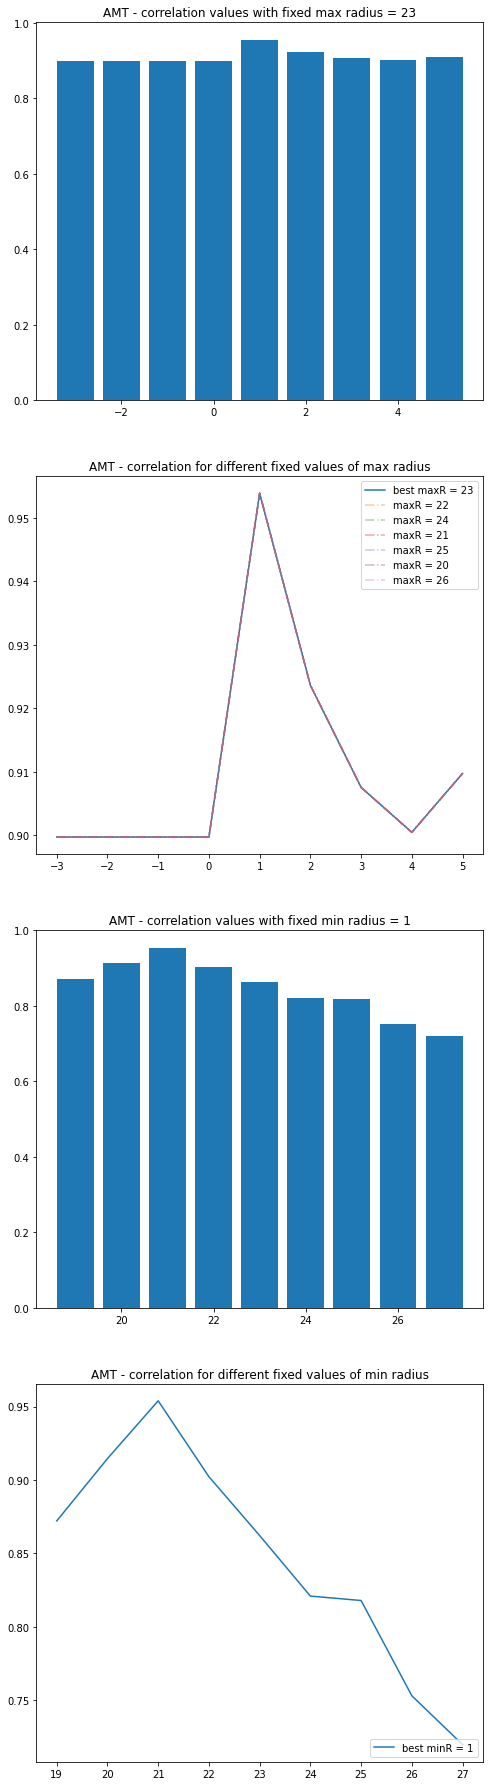

In [46]:
fig, ax_bar = plt.subplots(4,1, figsize=(8,32))

ax_bar[0].bar(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, :, best_MaxR_idx])
ax_bar[0].set_title('AMT - correlation values with fixed max radius = '+str(best_maxR_adaptive))

ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, :, best_MaxR_idx], label='best maxR = ' + str(best_maxR_adaptive))
for j in np.arange(1,4,1):
    ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, :, best_MaxR_idx], '-.', alpha = 0.4,  label="maxR = " +str(best_maxR_adaptive-j))
    ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, :, best_MaxR_idx], '-.', alpha = 0.4, label="maxR = " +str(best_maxR_adaptive+j))
ax_bar[1].legend(loc = 'upper right')
ax_bar[1].set_title('AMT - correlation for different fixed values of max radius')


ax_bar[2].bar(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, best_MinR_idx, :])
ax_bar[2].set_title('AMT - correlation values with fixed min radius = '+str(best_minR_adaptive))

ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, best_MinR_idx, :], label='best minR = ' + str(best_minR_adaptive))
for j in np.arange(1,4,1):
    if (best_minR_adaptive-j >0):
        ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, best_MinR_idx-1, :], '-.', alpha = 0.4,  label="minR = " +str(best_minR_adaptive-j))
        ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, best_MinR_idx-1, :], '-.', alpha = 0.4, label="minR = " +str(best_minR_adaptive+j))
ax_bar[3].legend(loc = 'lower right')
ax_bar[3].set_title('AMT - correlation for different fixed values of min radius')

plt.savefig(os.path.join(result_path, 'AMT_minMaxRadius_distribution.pdf'))


In [47]:
######################## ADAPTIVE GAUSSIAN THREE PARAMS GRID SEARCH######################

In [48]:
maxC = 60
minBsize = 3
maxBsize = 50

maxRadius = 50
minR =  best_minR_twoWay
struct_load = load_obj(dir_save = result_path_objs, file_name = 'adaptive_gauss_correl_dict')

if struct_load==None:

    adaptive_gauss_correl_dict = {}

    df_adaptive_gauss = np.zeros(shape=(len(range(0,maxC,4)),len(range(minBsize,maxBsize,2)), 1, maxRadius ))
    
    idx_C =-1   
    #for maxRadius in range(11,41,2):
    for C in range(0,maxC,4):
        idx_C = idx_C + 1  
        idx_b =-1
        for bsize in range(minBsize,maxBsize,4):
            idx_b = idx_b + 1
            #for minR in best_minR_twoWay:
            for maxR in range(15,45,1):            
                correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                adaptive_gauss_correl_dict[(bsize, C, minR, maxR)] = correl  
                df_adaptive_gauss[idx_C, idx_b, 0, maxR-1] = correl

    save_obj( obj = (adaptive_gauss_correl_dict, df_adaptive_gauss), dir_save = result_path_objs, file_name = 'adaptive_gauss_correl_dict')
else:
    adaptive_gauss_correl_dict = struct_load[0] 
    df_adaptive_gauss = struct_load[1]

    # get key with max value
(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive) = max(adaptive_gauss_correl_dict, key=adaptive_gauss_correl_dict.get)

print("best correlation on training set = "+str(adaptive_gauss_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE_GAUSSIAN ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 0
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 0
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 0
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 0
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 0
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 0
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 4
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 4
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 4
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 4
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 4
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 4
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 4
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 4
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 4
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 4
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 4
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 4
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 4
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 4
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 4
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 4
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 4
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 4
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 4
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 4
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 4
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 4
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 4
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 4
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 4
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 4
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 4
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 4
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 4
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 4
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 8
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 8
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 8
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 8
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 8
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 8
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 8
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 8
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 8
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 8
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 8
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 8
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 8
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 8
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 8
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 8
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 8
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 8
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 8
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 8
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 8
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 8
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 8
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 8
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 8
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 8
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 8
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 8
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 8
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 8
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 8
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 8
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 8
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 8
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 8
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 8
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 8
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 12
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 12
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 12
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 12
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 12
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 12
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 12
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 12
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 12
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 12
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 12
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 12
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 12
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 12
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 12
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 12
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 12
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 12
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 12
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 12
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 12
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 12
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 12
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 12
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 12
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 12
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 12
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 12
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 12
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 12
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 12
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 12
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 12
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 12
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 12
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 12
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 16
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 16
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 16
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 16
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 16
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 16
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 16
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 16
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 16
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 16
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 16
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 16
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 16
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 16
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 16
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 16
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 16
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 16
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresh

working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 20
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blo

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 20
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 20
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 20
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 20
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 20
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 20
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 20
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 20
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 20
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 20
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 20
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 24
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 24
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 24
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 24
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 24
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 24
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 24
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 24
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 24
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 24
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 24
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 24
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 24
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 24
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 24
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 24
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 24
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 24
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 24
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 24
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 24
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 24
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 24
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 24
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 24
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 24
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 24
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 24
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 24
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 24
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 24
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 24
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 24
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 24
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 24
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 24
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 24
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 24
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on threshold

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 28
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 28
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 28
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 28
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on threshold

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 28
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 28
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 28
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 28
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 28
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 28
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 28
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 28
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 28
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 28
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 28
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 28
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 28
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 28
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 28
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 28
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 28
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 28
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 28
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 28
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 28
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 28
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 32
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 32
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 32
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 32
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 32
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 32
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 32
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 32
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 32
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 32
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 32
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 32
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 32
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 32
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 32
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 32
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 32
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 32
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 32
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 32
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 32
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 32
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 32
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 32
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 32
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 32
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 32
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 32
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 32
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 32
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 32
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 32
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 32
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 32
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 32
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 32
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 32
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 32
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 32
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 32
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 32
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 32
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 36
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 36
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 36
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 36
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 36
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresh

working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 36
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSI

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 40
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 40
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 40
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 40
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 40
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 40
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 40
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 40
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 40
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 40
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 40
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 40
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 40
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 40
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 40
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 40
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 40
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 40
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 40
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 40
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 40
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 40
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 40
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 40
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 40
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 40
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 40
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 40
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 44
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 44
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 44
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 44
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 44
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 44
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 44
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 44
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 44
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 44
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 44
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 44
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 44
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 44
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 44
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 48
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 48
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 48
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 48
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 48
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 48
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 48
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 48
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 48
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 48
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 48
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 48
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 48
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 48
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 48
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 48
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 48
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 48
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 48
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 48
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 48
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 48
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 48
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 48
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 48
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 48
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 48
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 48
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 48
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 48
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 48
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 48
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 48
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 48
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 48
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 48
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 48
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 48
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 48
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 48
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 48
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 48
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 52
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 52
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 52
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 52
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 52
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 52
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 52
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 52
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 23 - C = 52
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 31 - C = 52
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 52
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 52
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 56
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 56
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on threshol

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 7 - C = 56
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 56
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 56
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 56
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 56
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 11 - C = 56
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on threshol

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 15 - C = 56
 - Hough minR = 9, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 56
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 56
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 56
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 56
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 56
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 19 - C = 56
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 56
 - Hough minR = 9, maxR = 15
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 56
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 56
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 56
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 56
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 56
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 27 - C = 56
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 56
 - Hough minR = 9, maxR = 16
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 56
 - Hough minR = 9, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 56
 - Hough minR = 9, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 56
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 56
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 56
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 35 - C = 56
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 56
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresh

In [49]:
######################### ADAPTIVE GAUSSIAN BEST C AND BSIZE RADIUSES SEARCH######################

In [50]:
bsize = best_b_size_adaptive
C = best_C_adaptive    
maxRadius = 50

struct_load = load_obj(dir_save = result_path_objs, file_name = 'adaptive_gauss_correl_dict_radiuses')

if struct_load==None:
    print('create dict')
    adaptive_mean_correl_dict = {}
    df_adaptive_mean = np.zeros(shape=(maxRadius, maxRadius ))
    for minR in range(1,maxRadius,1):
        for maxR in range(minR+1,maxRadius,1):            
            correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
            adaptive_mean_correl_dict[(minR, maxR)] = correl  
            df_adaptive_mean[minR-1, maxR-1] = correl

    save_obj( obj = (adaptive_mean_correl_dict, df_adaptive_mean), dir_save = result_path_objs, file_name = 'adaptive_gauss_correl_dict_radiuses')
else:
    adaptive_mean_correl_dict = struct_load[0] 
    df_adaptive_mean = struct_load[1]

    # get key with max value
(best_minR_adaptive, best_maxR_adaptive) = max(adaptive_mean_correl_dict, key=adaptive_mean_correl_dict.get)

print("best correlation = "+str(adaptive_mean_correl_dict[(best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE GAUSSIAN CORRELATION ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


create dict
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 1, maxR = 2
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 1, maxR = 3
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 1, maxR = 4
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 1, maxR = 5
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 1, maxR = 6
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 1, maxR = 7
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 1, maxR = 8
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_G

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 2, maxR = 17
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 2, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 2, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 2, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 2, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 2, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 2, maxR = 23
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 3, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 3, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 3, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 3, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 3, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 3, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 3, maxR = 38
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 4, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 4, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 5, maxR = 6
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 5, maxR = 7
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 5, maxR = 8
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 5, maxR = 9
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 5, maxR = 10
merging the dataframes
(10, 3)
working on thresholdi

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 6, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 6, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 6, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 6, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 6, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 6, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 6, maxR = 28
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 7, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 7, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 7, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 7, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 7, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 7, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 7, maxR = 47
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 10, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 10, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 10, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 10, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 10, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 10, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 10, maxR = 49
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 12, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 12, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 12, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 12, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 12, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 12, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 12, maxR = 35
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 18
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 24
merging the dataframes
(10, 3)
working on

/home/gpaolillo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/gpaolillo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 14, maxR = 33
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 16, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 16, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 16, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 16, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 16, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 16, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 16, maxR = 26
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 17, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 17, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 18, maxR = 19
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 18, maxR = 20
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 18, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 18, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 18, maxR = 23
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 19, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 19, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 19, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 20, maxR = 21
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 20, maxR = 22
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 20, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 20, maxR = 24
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 22, maxR = 23
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 22, maxR = 24
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 22, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 22, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 22, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 22, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 22, maxR = 29
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 24, maxR = 34
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 24, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 24, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 24, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 24, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 24, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 24, maxR = 40
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 26, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 26, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 27, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 27, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 27, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 27, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 27, maxR = 32
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 29, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 29, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 29, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 29, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 29, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 30, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 30, maxR = 32
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 33, maxR = 35
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 33, maxR = 36
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 33, maxR = 37
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 33, maxR = 38
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 33, maxR = 39
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 33, maxR = 40
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 33, maxR = 41
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 37, maxR = 41
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 37, maxR = 42
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 37, maxR = 43
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 37, maxR = 44
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 37, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 37, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 37, maxR = 47
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 44, maxR = 45
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 44, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 44, maxR = 47
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 44, maxR = 48
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 44, maxR = 49
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 45, maxR = 46
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 44
 - Hough minR = 45, maxR = 47
merging the dataframes
(10, 3)
working on

In [51]:
############ GLOBAL ADAPTIVE GAUSSIAN PARAM SEARCH ####################

In [52]:
struct_load = load_obj(dir_save = result_path_objs, file_name = 'global_adaptive_gauss_correl_dict')

if struct_load==None:

    adaptive_gauss_correl_dict = {}

    df_adaptive_gauss = np.zeros(shape=(10, 5, 9, 9))

    idx_C =-1   
    for C in range(best_C_adaptive-9,best_C_adaptive+10,2):
        idx_C = idx_C + 1  
        idx_b =-1
        if best_b_size_adaptive == 3:
            for bsize in range(best_b_size_adaptive,best_b_size_adaptive+9,2):
                idx_b = idx_b + 1
                idx_minR =-1
                for minR in range(best_minR_adaptive-4,best_minR_adaptive+5,1):
                    idx_minR = idx_minR + 1
                    idx_maxR =-1
                    for maxR in range(best_maxR_adaptive-4,best_maxR_adaptive+5,1):
                        idx_maxR = idx_maxR + 1
                        correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                        adaptive_gauss_correl_dict[(bsize, C, minR, maxR)] = correl  
                        df_adaptive_gauss[idx_C, idx_b, idx_minR, idx_maxR] = correl
        else:
            for bsize in range(best_b_size_adaptive-4,best_b_size_adaptive+5,2):
                idx_b = idx_b + 1
                idx_minR =-1
                for minR in range(best_minR_adaptive-4,best_minR_adaptive+5,1):
                    idx_minR = idx_minR + 1
                    idx_maxR =-1
                    for maxR in range(best_maxR_adaptive-4,best_maxR_adaptive+5,1):
                        idx_maxR = idx_maxR + 1
                        correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                        adaptive_gauss_correl_dict[(bsize, C, minR, maxR)] = correl  
                        df_adaptive_gauss[idx_C, idx_b, idx_minR, idx_maxR] = correl

    save_obj(obj = (adaptive_gauss_correl_dict, df_adaptive_gauss), dir_save = result_path_objs, file_name = 'global_adaptive_gauss_correl_dict')
else:
    adaptive_gauss_correl_dict = struct_load[0] 
    df_adaptive_gauss = struct_load[1]

    # get key with max value
(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive) = max(adaptive_gauss_correl_dict, key=adaptive_gauss_correl_dict.get)

print("best correlation on training set = "+str(adaptive_gauss_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE GAUSSIAN ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 4, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSI

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 10, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 11, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 11, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 11, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 11, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 11, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 35
 - Hough minR = 11, maxR = 30
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 35
 - Hough minR = 8, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 35
 - Hough minR = 8, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 35
 - Hough minR = 8, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 35
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 35
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 35
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 35
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 35
 - Hough minR = 6, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 35
 - Hough minR = 6, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 35
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 35
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 35
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 35
 - Hough minR = 7, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 35
 - Hough minR = 7, maxR = 26
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 4, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 4, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 4, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 11, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 11, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 11, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 11, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 11, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 11, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 35
 - Hough minR = 11, maxR = 31
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 35
 - Hough minR = 8, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 35
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 35
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 35
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 35
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 35
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 35
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresh

working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 37
 - Hough minR = 6, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 37
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 37
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 37
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 37
 - Hough minR = 7, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 37
 - Hough minR = 7, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 37
 - Hough minR = 7, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSI

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 4, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 4, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 4, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 11, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 11, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 11, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 11, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 11, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 11, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 37
 - Hough minR = 12, maxR = 25
merging the dataframes
(10, 3)
working on

(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 37
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 37
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 37
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 37
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 37
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 37
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 37
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIV

working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 37
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 37
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 37
 - Hough minR = 7, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 37
 - Hough minR = 7, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 37
 - Hough minR = 7, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 37
 - Hough minR = 7, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 37
 - Hough minR = 7, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSI

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 4, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 4, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 5, maxR = 28
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 11, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 11, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 11, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 11, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 12, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 12, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 37
 - Hough minR = 12, maxR = 27
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 39
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 39
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 39
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 39
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 39
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 39
 - Hough minR = 10, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 39
 - Hough minR = 10, maxR = 26
merging the dataframes
(10, 3)
working on thre

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 39
 - Hough minR = 7, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 39
 - Hough minR = 7, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 39
 - Hough minR = 7, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 39
 - Hough minR = 7, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 39
 - Hough minR = 7, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 39
 - Hough minR = 7, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 39
 - Hough minR = 7, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 5, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 5, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 5, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 11, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 12, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 12, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 12, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 12, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 12, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 39
 - Hough minR = 12, maxR = 30
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 39
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 39
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 39
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 39
 - Hough minR = 10, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 39
 - Hough minR = 10, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 39
 - Hough minR = 10, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 39
 - Hough minR = 10, maxR = 28
merging the dataframes
(10, 3)
working on th

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 39
 - Hough minR = 7, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 39
 - Hough minR = 7, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 39
 - Hough minR = 7, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 39
 - Hough minR = 7, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 39
 - Hough minR = 7, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 39
 - Hough minR = 8, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 39
 - Hough minR = 8, maxR = 26
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 5, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 5, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 5, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 5, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 5, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 12, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 12, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 12, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 12, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 12, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 12, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 41
 - Hough minR = 12, maxR = 32
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 41
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 41
 - Hough minR = 10, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 41
 - Hough minR = 10, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 41
 - Hough minR = 10, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 41
 - Hough minR = 10, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 41
 - Hough minR = 10, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 41
 - Hough minR = 10, maxR = 30
merging the dataframes
(10, 3)
working on 

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 41
 - Hough minR = 7, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 41
 - Hough minR = 7, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 41
 - Hough minR = 7, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 41
 - Hough minR = 8, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 41
 - Hough minR = 8, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 41
 - Hough minR = 8, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 41
 - Hough minR = 8, maxR = 28
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 5, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 5, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 5, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 5, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 6, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 6, maxR = 26
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 12, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 12, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 12, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 12, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 12, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 12, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 41
 - Hough minR = 12, maxR = 33
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 41
 - Hough minR = 10, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 41
 - Hough minR = 10, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 41
 - Hough minR = 10, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 41
 - Hough minR = 10, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 41
 - Hough minR = 10, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 41
 - Hough minR = 10, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 41
 - Hough minR = 10, maxR = 32
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 43
 - Hough minR = 7, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 43
 - Hough minR = 8, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 43
 - Hough minR = 8, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 43
 - Hough minR = 8, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 43
 - Hough minR = 8, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 43
 - Hough minR = 8, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 43
 - Hough minR = 8, maxR = 30
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 5, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 5, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 5, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 6, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 6, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 6, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 6, maxR = 28
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 12, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 12, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 12, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 43
 - Hough minR = 12, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on th

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 10, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 10, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 10, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 10, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 10, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 10, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 43
 - Hough minR = 11, maxR = 25
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 43
 - Hough minR = 8, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 43
 - Hough minR = 8, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 43
 - Hough minR = 8, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 43
 - Hough minR = 8, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 43
 - Hough minR = 8, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 43
 - Hough minR = 8, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 43
 - Hough minR = 8, maxR = 32
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 5, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 6, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 6, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 6, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 6, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 6, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 6, maxR = 30
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 12, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 43
 - Hough minR = 12, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thre

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 10, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 10, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 10, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 10, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 11, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 11, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 45
 - Hough minR = 11, maxR = 27
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 45
 - Hough minR = 8, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 45
 - Hough minR = 8, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 45
 - Hough minR = 8, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 45
 - Hough minR = 8, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 45
 - Hough minR = 8, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 45
 - Hough minR = 8, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 45
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 45
 - Hough minR = 6, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 45
 - Hough minR = 6, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 45
 - Hough minR = 6, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 45
 - Hough minR = 6, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 45
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 45
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 45
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 4, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 10, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 11, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 11, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 11, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 11, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 11, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 45
 - Hough minR = 11, maxR = 30
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 45
 - Hough minR = 8, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 45
 - Hough minR = 8, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 45
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 45
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 45
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 45
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 45
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 47
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 47
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 47
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 47
 - Hough minR = 7, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 47
 - Hough minR = 7, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 47
 - Hough minR = 7, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 47
 - Hough minR = 7, maxR = 28
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 4, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 4, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 4, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 11, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 11, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 11, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 11, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 11, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 12, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 47
 - Hough minR = 12, maxR = 26
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 47
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 47
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 47
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 47
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 47
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 47
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 47
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 47
 - Hough minR = 7, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 47
 - Hough minR = 7, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 47
 - Hough minR = 7, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 47
 - Hough minR = 7, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 47
 - Hough minR = 7, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 47
 - Hough minR = 7, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 47
 - Hough minR = 7, maxR = 32
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 5, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 5, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 5, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 5, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 5, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 5, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 11, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 11, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 12, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 12, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 12, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 12, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 47
 - Hough minR = 12, maxR = 29
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 49
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 49
 - Hough minR = 9, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 49
 - Hough minR = 9, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 49
 - Hough minR = 10, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 49
 - Hough minR = 10, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 49
 - Hough minR = 10, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 49
 - Hough minR = 10, maxR = 28
merging the dataframes
(10, 3)
working on th

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 49
 - Hough minR = 7, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 49
 - Hough minR = 7, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 49
 - Hough minR = 7, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 49
 - Hough minR = 7, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 49
 - Hough minR = 8, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 49
 - Hough minR = 8, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 49
 - Hough minR = 8, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 5, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 5, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 5, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 5, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 5, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 6, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 6, maxR = 26
merging the dataframes
(10, 3)
working on thresh

working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 12, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 12, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 12, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 12, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 12, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 49
 - Hough minR = 12, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 49
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 49
 - Hough minR = 10, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 49
 - Hough minR = 10, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 49
 - Hough minR = 10, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 49
 - Hough minR = 10, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 49
 - Hough minR = 10, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 49
 - Hough minR = 10, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 49
 - Hough minR = 10, maxR = 33
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 49
 - Hough minR = 8, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 49
 - Hough minR = 8, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 49
 - Hough minR = 8, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 49
 - Hough minR = 8, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 49
 - Hough minR = 8, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 49
 - Hough minR = 8, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 49
 - Hough minR = 8, maxR = 32
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 6, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 6, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 6, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 6, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 6, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 6, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 12, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 51
 - Hough minR = 12, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thre

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 10, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 10, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 10, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 11, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 11, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 11, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 51
 - Hough minR = 11, maxR = 28
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 51
 - Hough minR = 8, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 51
 - Hough minR = 8, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 51
 - Hough minR = 8, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 51
 - Hough minR = 8, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 51
 - Hough minR = 8, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 51
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 51
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 51
 - Hough minR = 6, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 51
 - Hough minR = 6, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 51
 - Hough minR = 6, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 51
 - Hough minR = 6, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 51
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 51
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 51
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 4, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 4, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 4, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 10, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 11, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 11, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 11, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 11, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 11, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 51
 - Hough minR = 11, maxR = 30
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 53
 - Hough minR = 8, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 53
 - Hough minR = 8, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 53
 - Hough minR = 8, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 53
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 53
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 53
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 39 - C = 53
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 53
 - Hough minR = 6, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 53
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 53
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 53
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 53
 - Hough minR = 7, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 53
 - Hough minR = 7, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 41 - C = 53
 - Hough minR = 7, maxR = 27
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 4, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 4, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 4, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 4, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 4, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 4, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 4, maxR = 33
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 11, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 11, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 11, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 11, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 11, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 11, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 43 - C = 53
 - Hough minR = 11, maxR = 32
merging the dataframes
(10, 3)
working on

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 53
 - Hough minR = 9, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 53
 - Hough minR = 9, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 53
 - Hough minR = 9, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 53
 - Hough minR = 9, maxR = 28
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 53
 - Hough minR = 9, maxR = 29
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 53
 - Hough minR = 9, maxR = 30
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 45 - C = 53
 - Hough minR = 9, maxR = 31
merging the dataframes
(10, 3)
working on thresh

merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 53
 - Hough minR = 6, maxR = 31
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 53
 - Hough minR = 6, maxR = 32
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 53
 - Hough minR = 6, maxR = 33
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 53
 - Hough minR = 7, maxR = 25
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 53
 - Hough minR = 7, maxR = 26
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 53
 - Hough minR = 7, maxR = 27
merging the dataframes
(10, 3)
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 47 - C = 53
 - Hough minR = 7, maxR = 28
merging the dataframes
(10, 3)
working on thresh

In [53]:
best_params_index = np.where(df_adaptive_gauss == adaptive_gauss_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])
best_B_idx = best_params_index[0][0]
best_C_idx = best_params_index[1][0]
best_MinR_idx = best_params_index[2][0]
best_MaxR_idx = best_params_index[3][0]
best_params_index

(array([5]), array([1]), array([3]), array([4]))

In [54]:
df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx, best_MaxR_idx]

0.9546938784804134

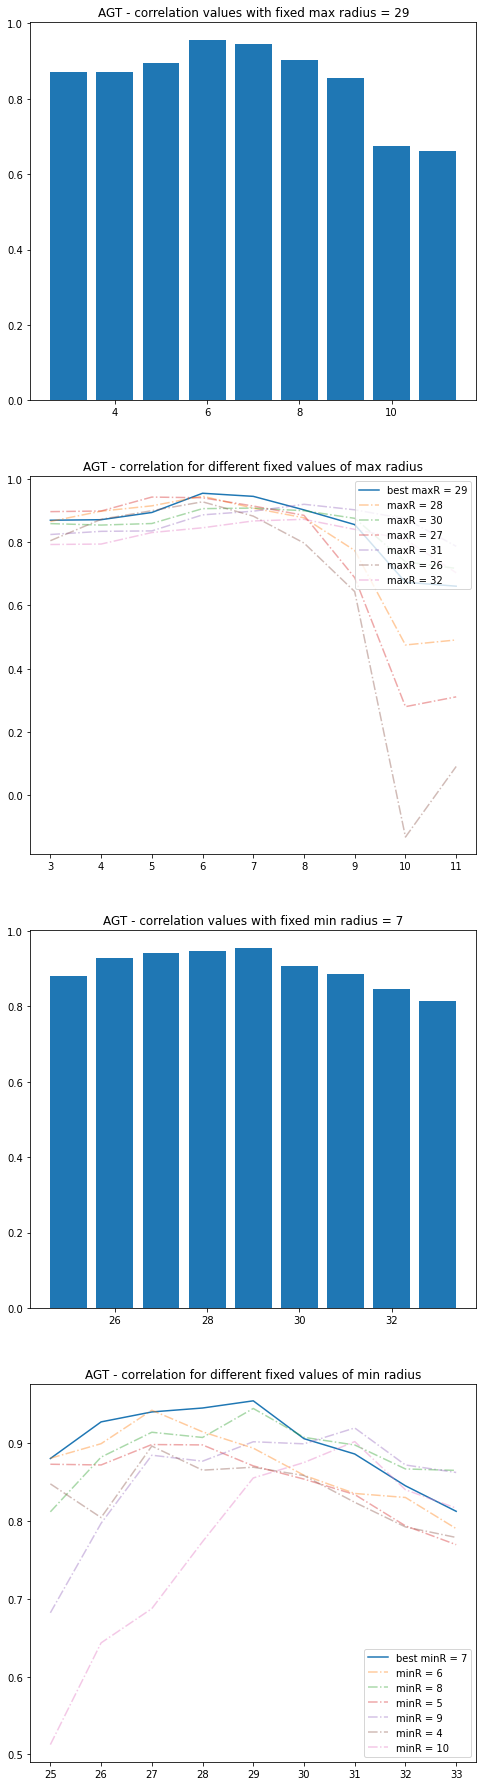

In [55]:
fig, ax_bar = plt.subplots(4,1, figsize=(8,32))

ax_bar[0].bar(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, :, best_MaxR_idx])
ax_bar[0].set_title('AGT - correlation values with fixed max radius = '+str(best_maxR_adaptive))

ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, :, best_MaxR_idx], label='best maxR = ' + str(best_maxR_adaptive))
for j in np.arange(1,4,1):
    ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, :, best_MaxR_idx-j], '-.', alpha = 0.4,  label="maxR = " +str(best_maxR_adaptive-j))
    ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, :, best_MaxR_idx+j], '-.', alpha = 0.4, label="maxR = " +str(best_maxR_adaptive+j))
ax_bar[1].legend(loc = 'upper right')
ax_bar[1].set_title('AGT - correlation for different fixed values of max radius')


ax_bar[2].bar(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx, :])
ax_bar[2].set_title('AGT - correlation values with fixed min radius = '+str(best_minR_adaptive))

ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx, :], label='best minR = ' + str(best_minR_adaptive))
for j in np.arange(1,4,1):
    if (best_minR_adaptive-j >0):
        ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx-j, :], '-.', alpha = 0.4,  label="minR = " +str(best_minR_adaptive-j))
        ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx+j, :], '-.', alpha = 0.4, label="minR = " +str(best_minR_adaptive+j))
ax_bar[3].legend(loc = 'lower right')
ax_bar[3].set_title('AGT - correlation for different fixed values of min radius')

plt.savefig(os.path.join(result_path, 'AGT_minMaxRadius_distribution.pdf'))
